In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy as sp
from pathlib import Path
from tkinter import filedialog
from colour import Color
from datetime import date
import cairo

## Names and Palette ##

In [4]:
today = date.today()
print("Today's date:", today)
date = str(today)
date

Today's date: 2023-10-05


'2023-10-05'

In [5]:
black = '#000000'
grey = '#777777'
blue = '#23459C'
cyan = '#0089CF'
green = '#79BA1A'
purple = '#AB4A9C'
lily = '#CB81EA'
magenta = '#D80B8C'
red = '#e60000'
orange = '#FF7300'
darkorange = '#FF5B00'
lightorange = '#FFAC83'
yellow = '#FFCB05'
lightyellow = '#F9DC2D'
pink = '#FFA4CD'

palette = [cyan, green]##... etc.

In [6]:
Type_order = ['None', 'Y64N','R76S','R102S', 'R178L', 'P191R', 'G223E','R303X', 'WT']

category_Type = CategoricalDtype(Type_order, ordered=True,) #order mutants

## Open data##

In [7]:
askmastersheet = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the selected file
data = pd.read_csv(askmastersheet, encoding='utf-8',keep_default_na=False)
data 

,Date,Investigator,CH,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues,DCX Type
0,2020-07-03,Sofia,13,12.0,0,3.9589999999999996,4.024,0.9838469184890656,0.9012083333333334,4.066,0.08383333333333334,48.50099403578528,False,None
1,2020-07-03,Sofia,13,12.0,0,7.49,7.8803333333333345,0.9504674083160608,0.14670833333333333,7.917999999999999,0.16766666666666669,47.224652087475135,False,None
2,2020-07-03,Sofia,13,12.0,0,3.21,3.5210000000000004,0.9116728202215278,0.2305416666666667,3.424,0.2515,13.61431411530815,False,None
3,2020-07-03,Sofia,13,12.0,0,12.84,14.3355,0.8956785602176416,0.8173750000000001,12.947000000000001,1.0898333333333334,11.879798134271295,False,None
4,2020-07-03,Sofia,13,12.0,0,3.424,3.9401666666666673,0.8689987733175414,0.6497083333333333,3.21,0.2515,12.763419483101393,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,2021-01-29,Sofia,22,6.0,227,3.7296347503662117,6.715666332244872,0.5553633200116854,0.6059301185607909,0.8453842468261719,0.4740459442138672,1.7833382125610475,True,WT
11304,2021-01-29,Sofia,22,6.0,227,6.115573440551758,10.743260841369626,0.5692474129458167,5.3058016586303705,1.044121856689453,0.7899464416503906,1.3217628457291712,True,WT
11305,2021-01-29,Sofia,22,6.0,227,4.376855890274048,8.415779170989987,0.5200773215819988,0.645753116607666,1.3428986949920654,0.3555963897705078,3.776468866454847,True,WT
11306,2021-01-29,Sofia,22,6.0,227,8.121382001876832,16.386183652877808,0.4956237629162982,0.5302767658233642,4.733320783615112,2.453969039916992,1.9288429098417732,True,WT


In [8]:
pathmastersheet = Path(askmastersheet)
resultdirectory = str(pathmastersheet.parents[0])+'//Plots_'+date
newmydir = Path(resultdirectory)
newmydir.mkdir(exist_ok=True)
path = newmydir
path


'C:\\Users\\Brouhard Lab\\OneDrive - McGill University\\EJCB2023\\Sofia_EJCB_Figs\\Data//Plots_2023-10-05'

In [79]:
data = data.dropna()

# Fitting Data #

In [67]:
def gaussian(x, mu, sig):
    return (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) )/(sig*np.sqrt(2*np.pi))

def exponential(x, scale):
    return ((np.exp(-x/scale) )/(scale))

def gamma(x, shape, scale):
    return (np.power(x,shape-1)*np.exp(-x/ scale))/(sp.special.gamma(shape) * np.power(scale,shape))


In [68]:
def make_hist(data, parameter, tubconc, dcxtype, dcxconc) :
    
    selectdata = data[(data[tubulin]==tubconc)&(data[Type]==dcxtype)&(data[DCXconc]==dcxconc)]
    
    maxbin = 30
    binsize = 1
        
    n, bins, patches = plt.hist(selectdata[parameter], bins=np.arange(0, maxbin + binsize, binsize), density=True);
    plt.clf()
       
    return n, bins

In [69]:
def equation_fit(data, parameter):
    
    equation = exponential
    
    results = pd.DataFrame(columns=[] , index=[])
    
    for tubconc in data[tubulin].unique():
        for dcxtype in data[Type].unique():
            for dcxconc in data[DCXconc].unique():

                    n, bins =  make_hist(data, parameter, tubconc, dcxtype, dcxconc)      

                    if np.isnan(np.sum(n)) == True:
                        continue
                        
                    else :
                        coeff, var_matrix = sp.optimize.curve_fit(equation,bins[:-1],n)

                    variance = np.diagonal(var_matrix) #Refer [3]
                    SE = np.sqrt(variance) #Refer [4]

                #======Making a data frame========
                    results0 = pd.DataFrame(columns=[] , index=[])
                    
                    for k in np.arange(0,len(coeff)):
                        
                        r0 = pd.DataFrame([[coeff[k],SE[k]],],columns=['Fit', 'SE'])
                        r0['Coefficient'] = k
                        results0 = pd.concat([results0, r0], sort=False)
                        
#                     for k in np.arange(0,len(coeff)):
#                         header = [np.array([parameter]),np.array(['Coefficient '+ str(k)])]
#                         r0 = pd.DataFrame([coeff[k],SE[k]], index=(['Value','SE']),columns= header)
#                         results0 = pd.concat([results0, r0], axis=1, sort=False)

                    results0[tubulin] = tubconc
                    results0[Type] = dcxtype
                    results0[DCXconc] = dcxconc
                    results0['Parameter'] = parameter

                    results = pd.concat([results, results0], sort=False)

    return results

In [70]:
newmydir = path/(date+'_fitdata')
newmydir.mkdir(exist_ok=True)
newmydir

WindowsPath('D:/Sofia/Data_Sheets_summer/Plots/2023-08-17_fitdata')

#  Open saved fit parameters  #

In [7]:
askFitParam = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the selected file
ResultFit = pd.read_csv(askFitParam, encoding='utf-8',keep_default_na=False)
ResultFit

,Fit,SE,Coefficient,[Tubulin] $(\mu M)$,DCX Type,[DCX] $(n M)$,Parameter,Moment
0,1.070577,0.008903,0.0,12.0,None,0,Growth Rate $(\mu m / min)$,Mean
1,0.157043,0.007290,1.0,12.0,None,0,Growth Rate $(\mu m / min)$,Std
2,0.797346,0.025314,0.0,8.0,None,0,Growth Rate $(\mu m / min)$,Mean
3,0.149149,0.020669,1.0,8.0,None,0,Growth Rate $(\mu m / min)$,Std
4,0.416686,0.002427,0.0,6.0,None,0,Growth Rate $(\mu m / min)$,Mean
...,...,...,...,...,...,...,...,...
363,5.080860,0.468668,1.0,14.0,None,0,Shrink Rate $(\mu m / min)$,Std
364,19.051355,0.549069,0.0,10.0,None,0,Shrink Rate $(\mu m / min)$,Mean
365,5.591572,0.456008,1.0,10.0,None,0,Shrink Rate $(\mu m / min)$,Std
366,12.426828,0.919834,0.0,7.0,None,0,Shrink Rate $(\mu m / min)$,Mean


In [8]:
newmydir = Path(askFitParam).parent
newmydir

WindowsPath('C:/Users/Brouhard Lab/OneDrive - McGill University/EJCB2023/Sofia_EJCB_Figs/Data/2023-08-08_fitdata-final')

# Histogram #

In [113]:
def plot_hist(data, tubconc, dcxtype, dcxconc,color) :
    
    selectdata = data[(data[tubulin]==tubconc)&(data[Type]==dcxtype)&(data[DCXconc]==dcxconc)]
    fig, ax = plt.subplots(2,2,figsize=(11.2,11))
    
    n = len(selectdata.dropna().index)
    
    c=0
    for i in np.arange(len(ax)):
        for j in np.arange(len(ax)):
            parameter = parameters[c]

            maxbin = 30
            binsize = 1

            ax[i][j].hist(selectdata[parameter], bins=np.arange(0, maxbin + binsize, binsize), 
                          density=True,histtype='stepfilled',color = color,alpha = 0.4);
            ax[i][j].set_xlabel(parameter)
            ax[i][j].set_ylabel('Probability Density')
            ax[i][j].set_xlim(0,maxbin)
            ax[0][0].set_xticks(np.arange(0, 1.6, 0.5))
            ax[i][j].spines['right'].set_visible(False)
            ax[i][j].spines['top'].set_visible(False)
            ax[i][j].spines['left'].set_lw(3)
            ax[i][j].spines['bottom'].set_lw(3)
            
            c += 1
    
    selectcoeff = ResultFit.dropna(subset=['Coefficient'])
    selectcoeff=selectcoeff[(selectcoeff[tubulin]==tubconc) & (selectcoeff[Type]==dcxtype) 
                            & (selectcoeff[DCXconc]==dcxconc)]
    
    x = np.arange(0, 1.5 + 0.025, 0.025)
    mu = selectcoeff[(selectcoeff['Parameter']==parameters[0]) & (selectcoeff['Coefficient']==0)]['Fit'].values
    sig = selectcoeff[(selectcoeff['Parameter']==parameters[0]) & (selectcoeff['Coefficient']==1)]['Fit'].values
    ax[0][0].plot(x, gaussian(x, mu, sig),color = color, lw=4);
    
    x = np.arange(0, 30 + 0.5, 0.5)
    scale = selectcoeff[(selectcoeff['Parameter']==parameters[1]) & (selectcoeff['Coefficient']==0)]['Fit'].values
    ax[0][1].plot(x, exponential(x, scale),color = color, lw=4);
    
    shape = selectcoeff[(selectcoeff['Parameter']==parameters[2]) & (selectcoeff['Coefficient']==0)]['Fit'].values
    scale = selectcoeff[(selectcoeff['Parameter']==parameters[2]) & (selectcoeff['Coefficient']==1)]['Fit'].values
    ax[1][0].plot(x, gamma(x, shape, scale),color = color, lw=4);
            
    mu = selectcoeff[(selectcoeff['Parameter']==parameters[3]) & (selectcoeff['Coefficient']==0)]['Fit'].values
    sig = selectcoeff[(selectcoeff['Parameter']==parameters[3]) & (selectcoeff['Coefficient']==1)]['Fit'].values
    ax[1][1].plot(x, gaussian(x, mu, sig),color = color, lw=4);
    
    legnd = str(dcxconc)+' nM'
    #ax[0][1].legend(('Fit',legnd),loc='upper right',title='DCX: '+dcxtype)
    #ax[1][0].legend(('Fit',legnd),loc='upper right',title='DCX: '+dcxtype)
    
    ax[0][0].set_ylim(0,6)
    ax[1][0].set_ylim(0,0.25)
    ax[0][1].set_ylim(0,0.6)
    ax[1][1].set_ylim(0,0.6)
    
    sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
    plt.tight_layout()
    
    #plt.savefig(newmydir/('joint_graphsHIST-'+dcxtype+'-'+str(dcxconc)+'-'+date+'.svg'))
    
    return print(n)

553


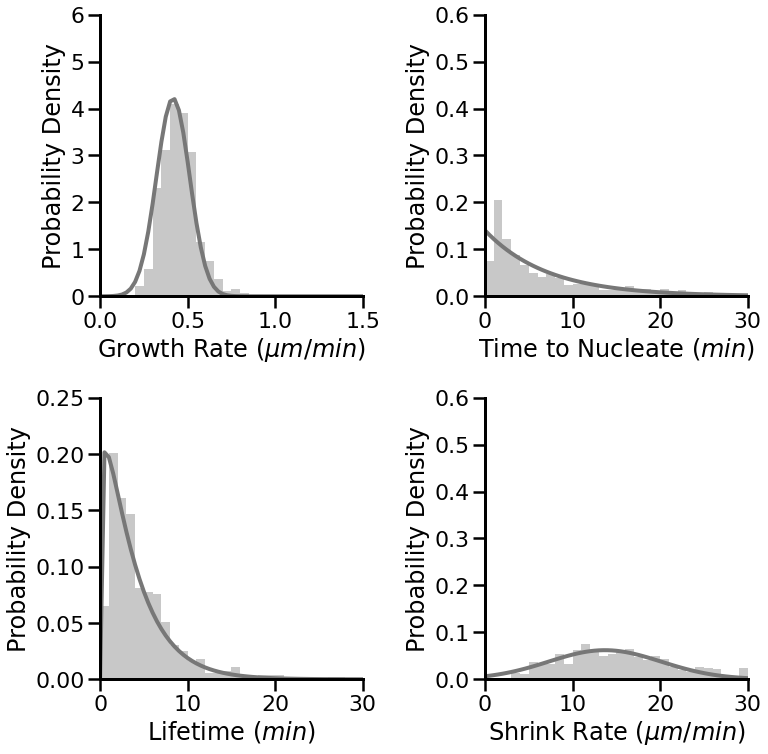

In [29]:
plot_hist(data, 6, 'None',0, grey00) #32,57,79,114,227 '#ff8341' orange ,'#e468b8' pink

## Plot fit ##

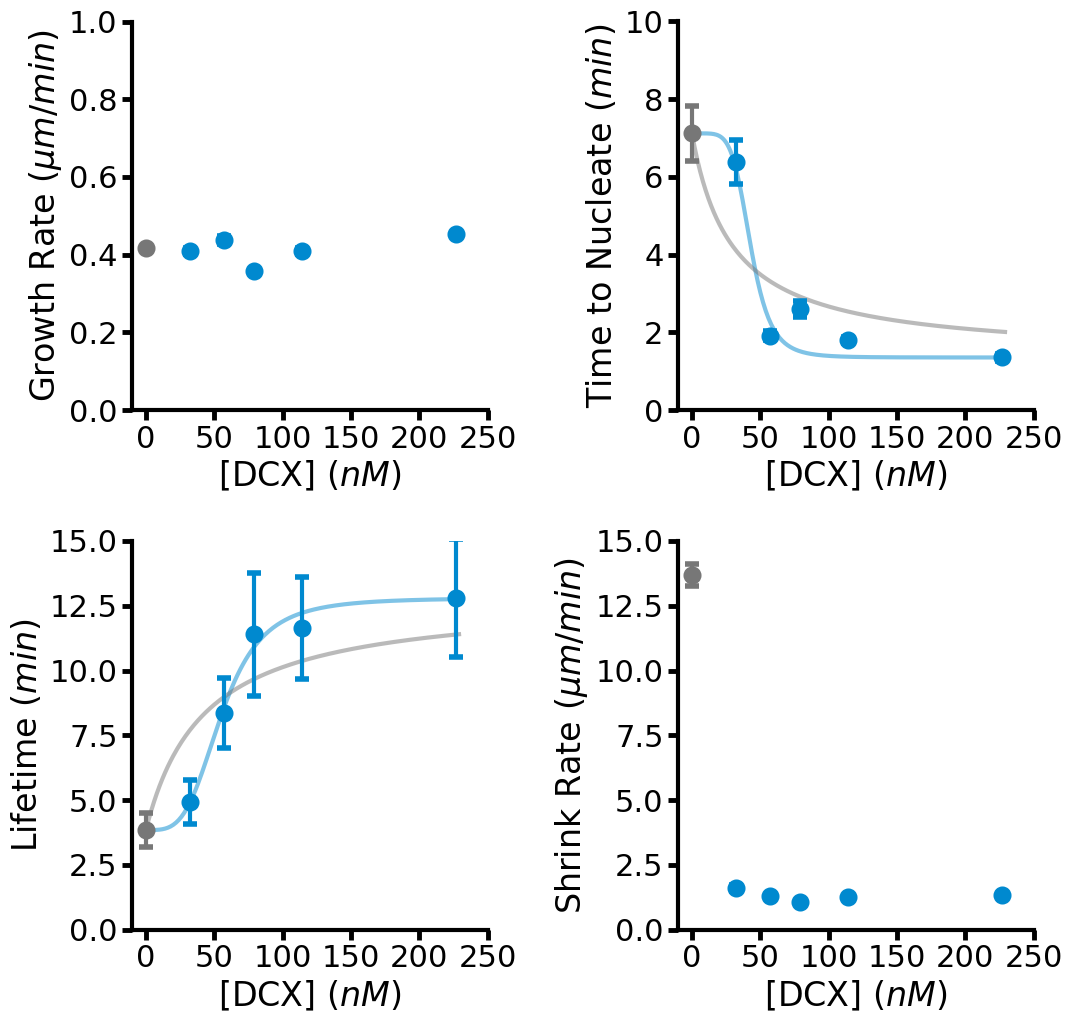

In [163]:
scattersize = 9
cap = 5

parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]
titles = ('Growth','Nucleation','Lifetime','Shrinkage Rate')
ylables = (GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate)

fig, ax = plt.subplots(2,2,figsize=(11.25,10.75))

linx = np.arange(0, 230, 1)


ax[1][0].plot(linx, hillEQ(linx,C1L, C2L),color = cyan, lw=3,ls= '-',alpha = 0.5)
ax[1][0].plot(linx, michaelis_menten(linx,coeff),color = grey, lw=3,ls= '-',alpha = 0.5)

ax[0][1].plot(linx, hillEQ_inv(linx, C1T, C2T) ,color = cyan, lw=3,ls= '-',alpha = 0.5)
ax[0][1].plot(linx, MMEQ_inv(linx, coeffMMN) ,color = grey, lw=3,ls= '-',alpha = 0.5)
# linx = np.arange(35, 230, 1)
# ax[1][0].plot(linx, linx*mL76+bL76 ,color = '#e468b8', lw=3,ls= '-',alpha = 0.5)
# ax[1][0].plot(linx, linx*mL191+bL191 ,color = '#ff8341', lw=3,ls= '-',alpha = 0.5)


count = 0

#palette = [grey,list(map(Color.get_hex,DC1color))[1],list(map(Color.get_hex,DC2color))[1],cyan] #+ list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]
palette = [grey,cyan]

for dcxtype in ['None','WT']:#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Moment']=='Mean')& (ResultFit[tubulin]==6)]
    
    c=0
    for i in np.arange(len(ax)):
        for j in np.arange(len(ax)):
    
            parameterMeanDF = dcxtype_DF[dcxtype_DF['Parameter']==parameters[c]]

            x = parameterMeanDF[DCXconc].values
            y = parameterMeanDF['Fit'].values
            yerr = parameterMeanDF['SE'].values
            
            if dcxtype == 'None' or  dcxtype == 'WT':

                ax[i][j].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
            else:
                ax[i][j].errorbar(x , y , yerr= yerr , fmt='--',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)

            c += 1

    count += 1

ax[0][0].set_ylim(0,1)
ax[1][0].set_ylim(0,15)
ax[0][1].set_ylim(0,10)
ax[1][1].set_ylim(0,15)


# linx = np.arange(30, 230, 1)
# ax[1][1].plot(linx, linx*mS+bS,color = cyan, lw=3,ls= '-',alpha = 0.5)

count = 0
for i in np.arange(len(ax)):
    for j in np.arange(len(ax)):
    
        ax[i][j].set_xlim(-10,250)
        ax[i][j].set_xlabel(DCXconc)
        ax[i][j].set_xticks(np.arange(0, 251, 50))
        ax[i][j].set_ylabel(ylables[count])
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['left'].set_lw(3)
        ax[i][j].spines['bottom'].set_lw(3)
        ax[i][j].tick_params(axis='both', width = 3.5, length = 7)
        #ax[i][1].legend((Type_order),loc='upper right',title='DCX Type')
        #ax[i][j].set_title(titles[count])
        
        count += 1

#ax[0][0].legend((Type_order),loc='upper right',title='DCX Type')
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
plt.tight_layout()

plt.savefig(newmydir/('dynamics_WT-2mutants'+date+'.svg'),backend='Cairo')